In [ ]:
import pandas as pd
import numpy as np

#seaborn이나 matplotlib 사용하기
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time

#sklearn 라이브러리를 사용하기
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight

%matplotlib inline
import matplotlib.gridspec as GridSpec

#pywt와  scipy라이브러리 사용하기
import pywt
from scipy import fftpack
from scipy import signal
from scipy import optimize
import itertools

In [ ]:
!pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 11.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=fac50141760b86141f8cc082955f50dee99ef35802fe1f8e8ecf00570a9c3710
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
from lifelines.utils import k_fold_cross_validation, median_survival_times
from lifelines import KaplanMeierFitter, CoxTimeVaryingFitter, NelsonAalenFitter,\
                      CoxPHFitter, WeibullAFTFitter, WeibullFitter, ExponentialFitter,\
                      LogNormalFitter, LogLogisticFitter
from lifelines.statistics import proportional_hazard_test
from lifelines.plotting import plot_lifetimes

In [ ]:
# 데이터 셋 불러오기(train 데이터, test 데이터, rul 데이터)
# def prepare_data():
#     dependent_var = ['RUL']
#     index_columns_names =  ["UnitNumber","Cycle"]
#     operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
#     sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
#     input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

#     df_train = pd.read_csv('/content/drive/MyDrive/CMAPSS/train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

#     rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
#     rul.columns = ['UnitNumber', 'max']
#     df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
#     df_train['RUL'] = df_train['max'] - df_train['Cycle']
#     df_train.drop('max', axis=1, inplace=True)

#     df_test = pd.read_csv('/content/drive/MyDrive/CMAPSS/test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

#     y_true = pd.read_csv('/content/drive/MyDrive/CMAPSS/RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
#     y_true["UnitNumber"] = y_true.index + 1

#     return df_train, df_test, y_true

In [ ]:
dir_path = '/Users/jinchan/edjjincode/NiseLabProject/Data/'
# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names
# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
df_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['time_cycles'])
# inspect first few rows
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
print(train.shape)
train[index_names+['RUL']].head()

(20631, 27)


,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [ ]:
# clip RUL max as 125 means values in column greater than 125 becomes 125
train['RUL'].clip(upper=125, inplace=True)

# drop non-informative features, derived from EDA
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = setting_names + drop_sensors
train.drop(labels=drop_labels, axis=1, inplace=True)

remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11',
                     's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
train.shape

(20631, 17)

In [ ]:
drop_labels

['setting_1',
 'setting_2',
 'setting_3',
 's_1',
 's_5',
 's_6',
 's_10',
 's_16',
 's_18',
 's_19']

In [ ]:
train

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,125
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,125
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,125
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,125
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [ ]:
# clip RUL max as 125 means values in column greater than 125 becomes 125
train['RUL'].clip(upper=125, inplace=True)

# drop non-informative features, derived from EDA
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = setting_names + drop_sensors
train.drop(labels=drop_labels, axis=1, inplace=True)

remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11',
                     's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
train.shape

KeyError: ignored

트레인 데이터에서 엔진이 고장 나는 순간은 마지막 순간이다. 마지막 순간은 breakdown 칼럼에 1을 놓고 나머지는 0을 적어준다.

In [ ]:
train['breakdown'] = 0
idx_last_record = train.reset_index().groupby(by='unit_nr')['index'].last()  # engines breakdown at the last cycle
train.loc[idx_last_record, 'breakdown'] = 1
# this start column is a lifelines specialty
train['start'] = train['time_cycles'] - 1
train.tail() # check results

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4,0,195
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3,0,196
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2,0,197
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1,0,198
20630,100,200,643.85,1600.38,1432.14,550.79,2388.26,9061.48,48.20,519.30,2388.26,8137.33,8.5036,396,38.37,23.0522,0,1,199


In [ ]:
idx_last_record = train.reset_index().groupby(by='unit_nr')['index'].last()  # engines breakdown at the last cycle
train.loc[idx_last_record, 'breakdown'] = 1

In [ ]:
train

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,125,0,0
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,125,0,1
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,125,0,2
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,125,0,3
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,125,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4,0,195
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3,0,196
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2,0,197
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1,0,198


In [ ]:
train

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,125,0,0
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,125,0,1
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,125,0,2
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,125,0,3
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,125,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4,0,195
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3,0,196
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2,0,197
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1,0,198


타임사이클이 200개 이하인 데이터에 대해서만 다룰 수 있도록 데이터 전처리를 하는 과정을 거친다.

In [ ]:
# cut off is the censoring cycle time line
cut_off = 200
train_censored = train[train['time_cycles'] <= cut_off].copy()
print(train_censored.shape)
train_censored[train_censored["unit_nr"] == 50].tail()

(18627, 19)


,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start
9904,50,194,643.77,1604.93,1423.51,551.41,2388.18,9128.75,48.16,519.85,2388.19,8194.20,8.5043,396,38.42,23.0543,4,0,193
9905,50,195,643.33,1605.31,1434.87,551.25,2388.17,9134.70,48.14,519.33,2388.21,8200.90,8.5352,395,38.45,23.0191,3,0,194
9906,50,196,643.32,1602.26,1430.01,551.40,2388.19,9129.59,48.24,519.88,2388.17,8194.10,8.5034,395,38.45,23.0379,2,0,195
9907,50,197,643.73,1599.94,1432.87,551.18,2388.19,9132.97,48.22,519.48,2388.20,8194.64,8.5241,397,38.52,23.0832,1,0,196
9908,50,198,643.83,1608.20,1433.88,552.06,2388.20,9128.91,48.01,520.00,2388.25,8200.20,8.5002,396,38.43,23.1086,0,1,197


In [ ]:
train_censored

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,125,0,0
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,125,0,1
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,125,0,2
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,125,0,3
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,125,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4,0,195
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3,0,196
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2,0,197
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1,0,198


## KaplaneMeierFitter()

생존 함수의 종류이다. 이 추정법은 관찰 시간이 짧을 때 부터 긴 순서로 나열해놓고 각 사건이 발생한 시점에서의 사건이 일어날 확률을 계산하는 비모수적 방법이다. 각 시점마다 구간 생존율을 구하여 이들을 누적시킴으로써 생성된 eCDF를 사용하여누적 생존 확률을 추정한다.

캐플런-마이어는 비모수 추정 기이기 때문에 데이터 분포에 대한 초기 가정을 할 필요가 없다. 또한 관측된 생존 기간의 생존 확률을 계산하여 우측 관측 중단 관측치를 처리한다. 확률의 곱 규칙을 사용한다.

t_i 시간에서 생존 확률은 이전 시간 t_i-1에서의 생존 확률과 t_i에서의 생존 확률의 백분율의 곱과 같다.

캐플런-마이어 방법은 전체 연구 기간 동안에 사건이 발생한 시점마다 구간 생존율을 산출하여 최종적으로는 누적생존율을 산출한다. 이 때문에 누적한 계축정법으로 불리기도 한다. 사건이 발생한 시점마다 생존율을 계산한다.

아래 그래프는 캐플란 마이어 생존 곡선이며 x 축은 사건 발생 시간, 추정된 생존 확률을 y축으로 갖는다. 생존 확률은 0에서 1사이의 값을 가지며 하향곡선을 그린다.

(100, 2)


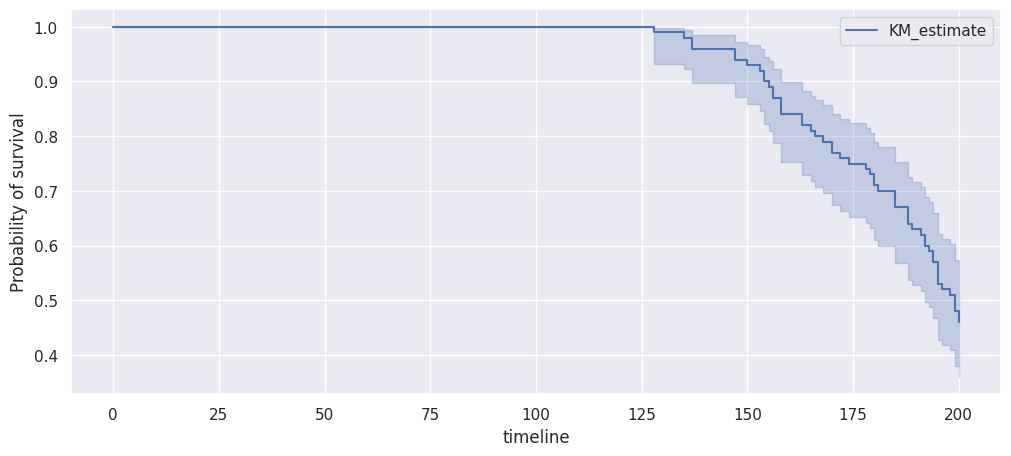

,time_cycles,breakdown
unit_nr,,
96,200,0
97,200,0
98,156,1
99,185,1
100,200,1


In [ ]:
data = train_censored[index_names+['breakdown']].groupby('unit_nr').last()
print(data.shape)
plt.figure(figsize=(12,5))
survival = KaplanMeierFitter()
survival.fit(data['time_cycles'], data['breakdown'])
survival.plot()
plt.ylabel("Probability of survival")
plt.show()
plt.close()
data.tail()

각 시점마다 구간 생존율을 구하여 이들을 누적시킨 것을 표현한 것이다.

<Axes: xlabel='timeline'>

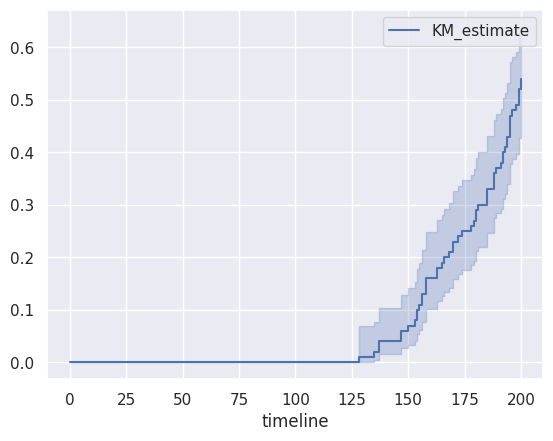

In [ ]:
survival.plot_cumulative_density()

In [ ]:
median_ = survival.median_survival_time_
median_confidence_interval_ = median_survival_times(survival.confidence_interval_)
print(median_)
print(median_confidence_interval_)

199.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   192.0                     inf


누적위험함수를 추정할 때 Nelson-Aalen estimator로 추정할 수 있다.

<Axes: xlabel='timeline'>

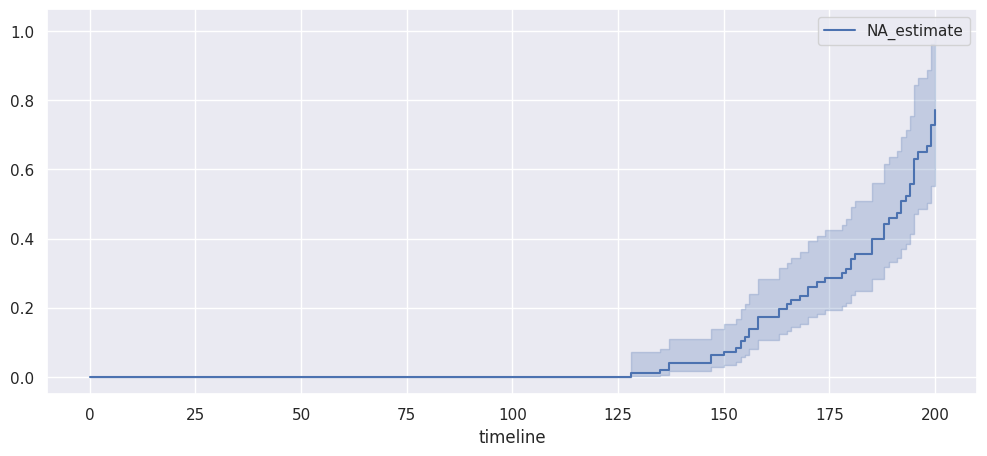

In [ ]:
naf = NelsonAalenFitter()
naf.fit(data['time_cycles'], data['breakdown'])
plt.figure(figsize=(12,5))
naf.plot()

<Axes: >

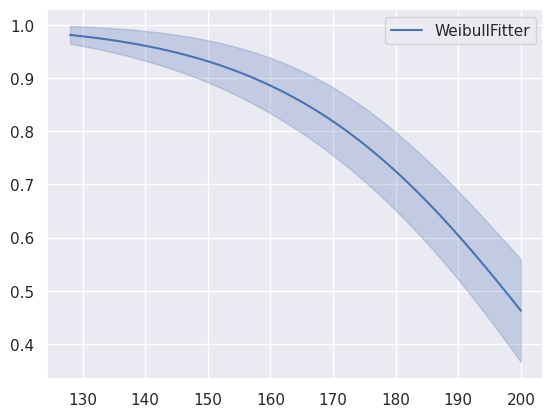

In [ ]:
wbf = WeibullFitter().fit(data['time_cycles'], data['breakdown'], label='WeibullFitter')
wbf.plot_survival_function()

앞서 언급한 Kaplan-Meier estimation도 생존과 이탈을 예측하는 가장 단순한 방법이다.

예를 들어 지금까지 신규 가입 고객 10억명 중 20%가 한 달 내 이탈하는 양상을 보였다면, 오늘 가입한 천 만명 중 20%는 한 달 내 이탈할 것이라 단순히 예측할 수 있다. 하지만 이는 각 대상의 데이터, 즉 feature를 전혀 고려하지 않은 것이다. feature 별로 이탈 확률이 다르다면 더 나은 예측을 할 수 있다.

Survival Prediction 관련 연구는 크게 네가지로 나뉜다.



1.   Non-parametric: 데이터의 feature와 생존 시간 분포 정보를 사용하지 않는 방법이다. 분포 정보를 알 수 없을 때 유용하지만 예측이 부정확할 수 있다.
2.  Semi-parametric: feature 정보를 활용하지만, 생존 시간 분포 정보를 사용하지 않는 방법이다. Cox Proportional Hazard 모델이 해당한다.
3. Parametric: 생존 시간 분포가 존재한다고 가정하고 회귀 모델로 생존 시간을 예측하는 기법이다. 지수 분포, 베이불 분포, 로지스틱 분포, 정규 분포 등을 사용한다.



# Cox PH model

KM 분석은 하나의 타겟 특성 이외의 다른 factor들을 통제할 수 없다는 점에서 한계를 가지고 있다. 이를 보완하는 것이 cox 모형이다.

Cox 비례 위험 모형은 공변량과 생존 함수를 결합한 모델이며, 특정 분포만을 고려하지 않고 데이터의 변량 여러개가 사건 발생에 영향을 미치는 다변량 생존 회귀분석법이라고는 하나, 정확히는 시간이라는 종속 변수 하나만을 갖는 단변수 생존 분석법이다.

시간 종속 변수에서 어떤 시점 t까지 생존한 사람이 직후에 사망할 조건부확률은 다음과 같이 나타낼 수 있다.

h(t∣X=x)=h
0
​
 (t)exp(x
T
 β)

 여기서 β는 각 공변량들의 계수로 구성된 벡터이고 h
0
​
 (t)는 공변량들이 0일 때 기저위험함수이다.


위험함수 Cox의 비례위험 모형은 두 가지 가정을 따른다.



1.   위험비가 일정하다는 비례위험가정
2.   관측치는 서로 독립적이며, 공변량이 위험 함수에 선형 곱셈 효과를 갖는 지수함수를 따라 특정 시점의 생존함수가 위험비에 따라 지수함수로 나타난다는 것이다.



In [ ]:
train_cols = index_names + remaining_sensors + ['start', 'breakdown']
predict_cols = ['time_cycles'] + remaining_sensors + ['start', 'breakdown']  # breakdown value will be 0
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(train_censored[train_cols], id_col="unit_nr", event_col='breakdown',
        start_col='start', stop_col='time_cycles', show_progress=True)

Iteration 1: norm_delta = 1.26e-01, step_size = 0.9500, log_lik = -230.78680, newton_decrement = 2.02e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.74e-03, step_size = 0.9500, log_lik = -210.58504, newton_decrement = 5.76e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.40e-04, step_size = 0.9500, log_lik = -210.52760, newton_decrement = 1.47e-04, seconds_since_start = 0.1
Iteration 4: norm_delta = 1.79e-05, step_size = 1.0000, log_lik = -210.52745, newton_decrement = 3.67e-07, seconds_since_start = 0.1
Iteration 5: norm_delta = 2.37e-11, step_size = 1.0000, log_lik = -210.52745, newton_decrement = 6.40e-19, seconds_since_start = 0.1
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 18627 periods, 100 subjects, 54 events>

<lifelines.CoxTimeVaryingFitter: fitted with 18627 periods, 100 subjects, 54 events>
         event col = 'breakdown'
         penalizer = 0.1
number of subjects = 100
 number of periods = 18627
  number of events = 54
partial log-likelihood = -210.53
  time fit was run = 2023-09-30 11:16:57 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
s_2         0.07       1.07       0.05            -0.02             0.17                 0.98                 1.18
s_3         0.01       1.01       0.00            -0.00             0.01                 1.00                 1.01
s_4         0.01       1.01       0.00            -0.00             0.01                 1.00                 1.01
s_7        -0.05       0.95       0.03            -0.10             0.01                 0.90                 1.01
s_8         0.53       1.70       0.33            -0.13             1.18                 0.88                 3.27
s_9         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
s_11        0.17       1.18       0.09            -0.01             0.35                 0.99                 1.41
s_12       -0.06       0.94       0.03            -0.12             0.01                 0.88                 1.01
s_13        0.55       1.73       0.33            -0.10             1.20                 0.91                 3.30
s_14        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
s_15        1.09       2.97       0.65            -0.19             2.36                 0.83                10.60
s_17        0.02       1.02       0.02            -0.01             0.05                 0.99                 1.06
s_20       -0.23       0.79       0.13            -0.50             0.03                 0.61                 1.03
s_21       -0.36       0.70       0.22            -0.80             0.08                 0.45                 1.09

            cmp to     z    p   -log2(p)
covariate                               
s_2           0.00  1.46 0.14       2.80
s_3           0.00  1.43 0.15       2.72
s_4           0.00  1.91 0.06       4.15
s_7           0.00 -1.73 0.08       3.57
s_8           0.00  1.58 0.11       3.14
s_9           0.00  0.72 0.47       1.08
s_11          0.00  1.81 0.07       3.83
s_12          0.00 -1.76 0.08       3.66
s_13          0.00  1.67 0.10       3.39
s_14          0.00  0.47 0.64       0.65
s_15          0.00  1.67 0.09       3.40
s_17          0.00  1.47 0.14       2.82
s_20          0.00 -1.75 0.08       3.63
s_21          0.00 -1.58 0.11       3.14
---
Partial AIC = 449.05
log-likelihood ratio test = 40.52 on 14 df
-log2(p) of ll-ratio test = 12.21

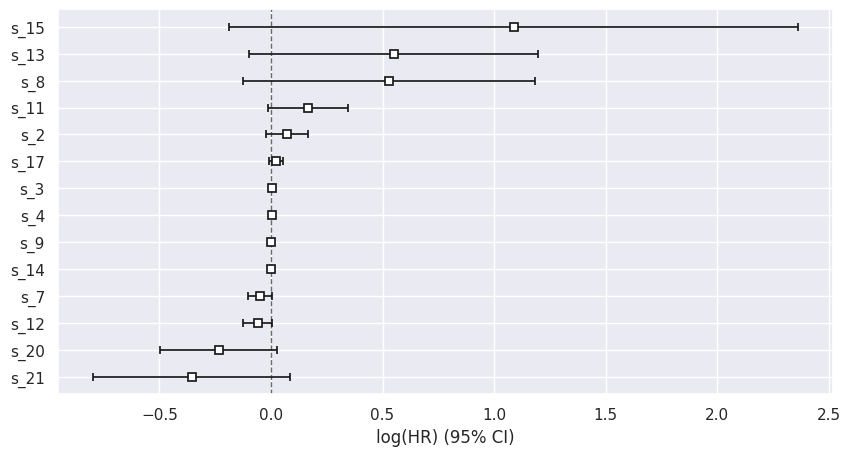

In [ ]:
ctv.print_summary()
plt.figure(figsize=(10,5))
ctv.plot()
plt.show()
plt.close()

In [ ]:
# get the last unit time series data frame
df = train_censored.groupby("unit_nr").last()
df = df[df['breakdown'] == 0]  # get engines from dataset which are still functioning so we can predict their RUL
df_to_predict = df.copy().reset_index()
# predictions = pd.DataFrame(ctv.predict_log_partial_hazard(df_to_predict[predict_cols]), index=df_to_predict.index)
predictions = ctv.predict_log_partial_hazard(df_to_predict[predict_cols]).to_frame()
predictions.rename(columns={0: "predictions"}, inplace=True)
df_last = train.groupby('unit_nr').last()
predictions['RUL'] = df_to_predict['RUL']
predictions.head(10)

,predictions,RUL
0,-0.086898,87
1,-0.099888,69
2,0.197106,59
3,1.373235,1
4,0.650010,22
5,0.255813,40
6,0.791317,7
7,1.080026,9
8,-0.151703,76
9,0.548900,34


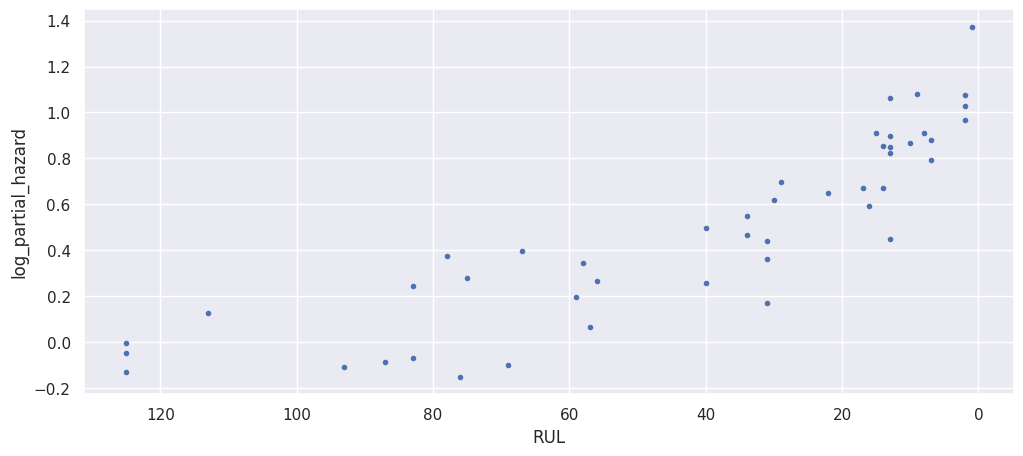

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(predictions['RUL'], predictions['predictions'], '.b')
xlim = plt.gca().get_xlim()
plt.xlim(xlim[1], xlim[0])
plt.xlabel('RUL')
plt.ylabel('log_partial_hazard')
plt.show()

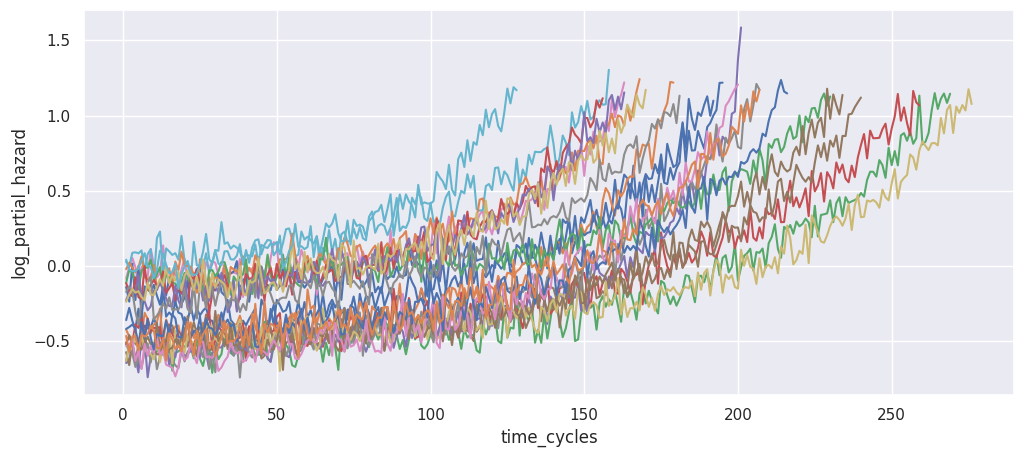

In [ ]:
# now lets look at some hazard trajectories
X = train.loc[train['unit_nr'].isin(df_to_predict.index)]
X_unique = len(X['unit_nr'].unique())
plt.figure(figsize=(12,5))
for i in range(1, X_unique, 2):
    X_sub = X.loc[X['unit_nr'] == i]
    predictions = ctv.predict_partial_hazard(X_sub).values
    plt.plot(X_sub['time_cycles'].values, np.log(predictions))

plt.xlabel('time_cycles')
plt.ylabel('log_partial_hazard')
plt.show()

In [ ]:
df_hazard = train_censored.copy().reset_index()
df_hazard['hazard'] = ctv.predict_log_partial_hazard(df_hazard)
df_hazard.head()

,index,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,...,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start,hazard
0,0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,...,2388.02,8138.62,8.4195,392,39.06,23.4190,125,0,0,-0.360719
1,1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,...,2388.07,8131.49,8.4318,392,39.00,23.4236,125,0,1,-0.279367
2,2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,...,2388.03,8133.23,8.4178,390,38.95,23.3442,125,0,2,-0.364185
3,3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,...,2388.08,8133.83,8.3682,392,38.88,23.3739,125,0,3,-0.424523
4,4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,...,2388.04,8133.80,8.4294,393,38.90,23.4044,125,0,4,-0.284539


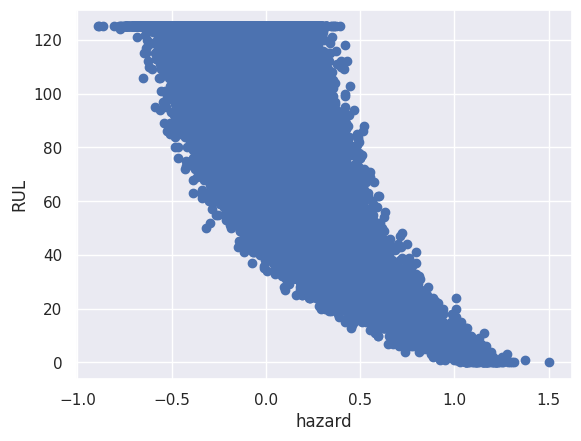

In [ ]:
plt.scatter(df_hazard['hazard'], df_hazard['RUL'])
plt.xlabel('hazard')
plt.ylabel('RUL')
plt.show()

In [ ]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

def exponential_model(z, a, b):
    return a * np.exp(-b * z)

popt, pcov = curve_fit(exponential_model, df_hazard['hazard'], df_hazard['RUL'])
print(popt)

[88.55861057  0.80713244]


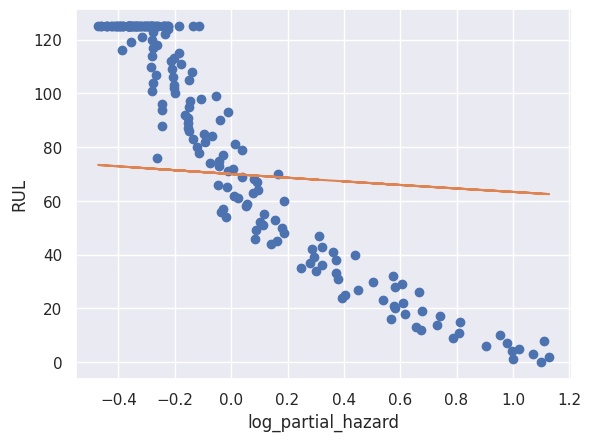

In [ ]:
#Idea of fit: The line that was actually fitted is less accurate as it takes data points of all engines into account.
# check specific unit_nr
y_hat = exponential_model(df_hazard.loc[df_hazard['unit_nr']==1, 'hazard'], 70, 0.1)
plt.plot(df_hazard.loc[df_hazard['unit_nr']==1, 'hazard'], df_hazard.loc[df_hazard['unit_nr']==1, 'RUL'], 'o',
         df_hazard.loc[df_hazard['unit_nr']==1, 'hazard'], y_hat)
plt.xlabel("log_partial_hazard")
plt.ylabel("RUL")
plt.show()
plt.close()

In [ ]:
test

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [ ]:
# prep test set
test = test.drop(labels=drop_labels, axis=1)
test['breakdown'] = 0
test['start'] = test['time_cycles'] - 1

# predict and evaluate
y_hat = exponential_model(df_hazard['hazard'], *popt)
evaluate(df_hazard['RUL'], y_hat, 'train')

y_pred = ctv.predict_log_partial_hazard(test.groupby('unit_nr').last())
y_hat = exponential_model(y_pred, *popt)
evaluate(df_test, y_hat)

train set RMSE:26.200901103670677, R2:0.5522512115651163
test set RMSE:27.12039731476559, R2:0.5740755697414878


In [ ]:
ctv2 = CoxTimeVaryingFitter()
ctv2.fit(train[train_cols], id_col="unit_nr", event_col='breakdown',
         start_col='start', stop_col='time_cycles', show_progress=True)

train['hazard'] = ctv2.predict_log_partial_hazard(train)
popt2, pcov2 = curve_fit(exponential_model, train['hazard'], train['RUL'])

y_hat = exponential_model(train['hazard'], *popt2)
evaluate(train['RUL'], y_hat, 'train')

y_pred = ctv2.predict_log_partial_hazard(test.groupby('unit_nr').last())
y_hat = exponential_model(y_pred, *popt2)
evaluate(df_test, y_hat)

Iteration 1: norm_delta = 1.00e+00, step_size = 0.9500, log_lik = -363.73938, newton_decrement = 1.69e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.23e+00, step_size = 0.9500, log_lik = -196.95744, newton_decrement = 6.53e+01, seconds_since_start = 0.1
Iteration 3: norm_delta = 7.49e-01, step_size = 0.9500, log_lik = -141.32406, newton_decrement = 2.53e+01, seconds_since_start = 0.1
Iteration 4: norm_delta = 7.27e-01, step_size = 0.9310, log_lik = -129.43964, newton_decrement = 1.68e+01, seconds_since_start = 0.1
Iteration 5: norm_delta = 2.30e-01, step_size = 1.0000, log_lik = -115.92018, newton_decrement = 1.13e+00, seconds_since_start = 0.2
Iteration 6: norm_delta = 4.04e-02, step_size = 1.0000, log_lik = -114.78357, newton_decrement = 1.24e-02, seconds_since_start = 0.2
Iteration 7: norm_delta = 5.62e-04, step_size = 1.0000, log_lik = -114.77107, newton_decrement = 2.21e-06, seconds_since_start = 0.2
Iteration 8: norm_delta = 1.18e-07, step_size = 1.0000, log_lik = -11

In [ ]:

def calculate_mse(y_true, y_pred):
    """
    MSE(평균 제곱 오차) 계산 함수

    Parameters:
    y_true (array-like): 실제 값의 배열 또는 리스트
    y_pred (array-like): 예측 값의 배열 또는 리스트

    Returns:
    float: MSE 값
    """
    squared_errors = [(true - pred) ** 2 for true, pred in zip(y_true, y_pred)]
    mse = np.mean(squared_errors)
    return mse

In [ ]:
def mse_evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    print('{} set MSE:{}'.format(label, mse))

In [ ]:
mse_evaluate(df_test, y_hat)

test set MSE:706.5489660693307


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def calculate_rmse(y_true, y_pred):
    """
    RMSE(평균 제곱근 오차) 계산 함수

    Parameters:
    y_true (array-like): 실제 값의 배열 또는 리스트
    y_pred (array-like): 예측 값의 배열 또는 리스트

    Returns:
    float: RMSE 값
    """
    mse = mean_squared_error(y_true, y_pred)  # 평균 제곱 오차(MSE) 계산
    rmse = np.sqrt(mse)  # MSE의 제곱근을 계산하여 RMSE를 얻음
    return rmse


In [ ]:
calculate_rmse(df_test, y_hat)

In [ ]:
y_hat

0     112.676254
1      86.030731
2      63.477739
3      73.923269
4      76.740836
         ...    
95    129.985831
96     83.046229
97     75.664610
98    125.753163
99     52.779935
Length: 100, dtype: float64

In [ ]:
df_test

,time_cycles
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


Iteration 1: norm_delta = 9.25e+00, step_size = 0.9500, log_lik = -375.89040, newton_decrement = 1.48e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 8.70e+00, step_size = 0.2375, log_lik = -313.76522, newton_decrement = 1.05e+02, seconds_since_start = 0.0
Iteration 3: norm_delta = 8.73e+00, step_size = 0.0772, log_lik = -298.15684, newton_decrement = 9.65e+01, seconds_since_start = 0.0
Iteration 4: norm_delta = 8.75e+00, step_size = 0.0246, log_lik = -293.47048, newton_decrement = 9.40e+01, seconds_since_start = 0.0
Iteration 5: norm_delta = 8.75e+00, step_size = 0.0078, log_lik = -292.00388, newton_decrement = 9.33e+01, seconds_since_start = 0.1
Iteration 6: norm_delta = 8.76e+00, step_size = 0.0025, log_lik = -291.53932, newton_decrement = 9.30e+01, seconds_since_start = 0.1
Iteration 7: norm_delta = 8.76e+00, step_size = 0.0008, log_lik = -291.39162, newton_decrement = 9.29e+01, seconds_since_start = 0.1
Iteration 8: norm_delta = 8.76e+00, step_size = 0.0003, log_lik = -29

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1165: ConvergenceWarning: Column start has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


<Axes: >

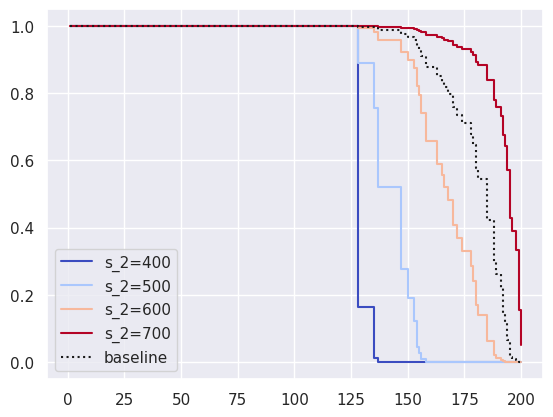

In [ ]:
cph = CoxPHFitter()
cph.fit(train_censored[train_cols], duration_col='time_cycles', event_col='breakdown', show_progress=True)
cph.plot_covariate_groups('s_2', [400, 500, 600, 700], cmap='coolwarm')

<Axes: >

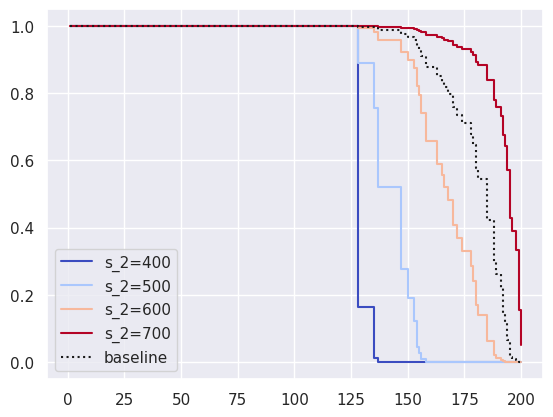

In [ ]:
cph.plot_partial_effects_on_outcome(covariates="s_2", values=[400, 500, 600, 700], cmap='coolwarm')

398.92035784221997
398.87053729259577


<lifelines.WeibullAFTFitter: fitted with 18627 total observations, 18573 right-censored observations>
             duration col = 'time_cycles'
                event col = 'breakdown'
   number of observations = 18627
number of events observed = 54
           log-likelihood = -287.62
         time fit was run = 2023-09-26 11:08:41 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                         
lambda_ s_11       -0.00       1.00       0.08            -0.16             0.15                 0.85                 1.16
        s_12        0.03       1.03       0.03            -0.02             0.09                 0.98                 1.09
        s_13       -0.14       0.87       0.25            -0.62             0.34                 0.54                 1.41
        s_14        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        s_15       -0.24       0.79       0.42            -1.07             0.60                 0.34                 1.82
        s_17       -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
        s_2        -0.04       0.96       0.03            -0.10             0.02                 0.91                 1.02
        s_20        0.33       1.39       0.15             0.04             0.62                 1.04                 1.85
        s_21        0.35       1.42       0.18            -0.01             0.71                 0.99                 2.04
        s_3        -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
        s_4        -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
        s_7         0.06       1.06       0.03            -0.01             0.12                 0.99                 1.13
        s_8         0.13       1.14       0.19            -0.25             0.50                 0.78                 1.65
        s_9        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        Intercept   5.49     242.47     504.83          -983.95           994.93                 0.00                  inf
rho_    s_11       -1.95       0.14       1.02            -3.94             0.05                 0.02                 1.05
        s_12        0.95       2.57       0.30             0.35             1.54                 1.42                 4.66
        s_13       -3.25       0.04       3.38            -9.87             3.38                 0.00                29.26
        s_14       -0.00       1.00       0.02            -0.05             0.05                 0.95                 1.05
        s_15       -8.93       0.00       5.88           -20.46             2.60                 0.00                13.44
        s_17       -0.14       0.87       0.10            -0.33             0.04                 0.72                 1.04
        s_2         0.42       1.53       0.33            -0.22             1.07                 0.80                 2.91
        s_20       -0.06       0.94       1.00            -2.02             1.89                 0.13                 6.62
        s_21       -2.47       0.08       1.53            -5.48             0.53                 0.00                 1.70
        s_3         0.04       1.04       0.03            -0.02             0.09                 0.98                 1.09
        s_4        -0.04       0.96       0.03            -0.09             0.02                 0.91                 1.02
        s_7         0.47       1.60       0.34            -0.21             1.14                 0.81                 3.13
        s_8         2.93      18.73       3.30            -3.53             9.39           

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

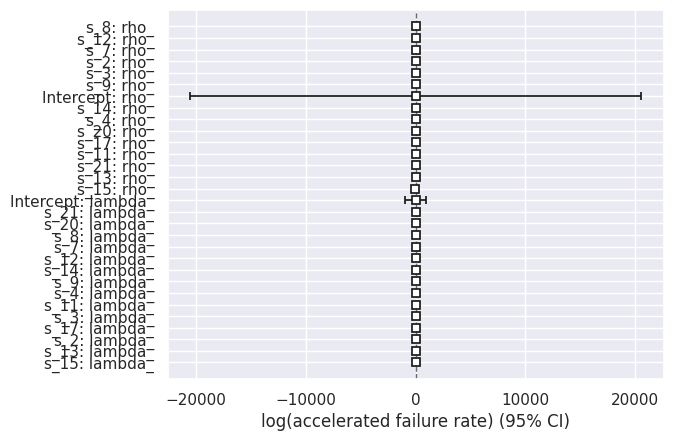

In [ ]:
aft = WeibullAFTFitter()
train_cols1 = ['time_cycles'] + remaining_sensors + ['breakdown']
aft.fit(train_censored[train_cols1], duration_col='time_cycles', event_col='breakdown', ancillary=True)
print(aft.median_survival_time_)
print(aft.mean_survival_time_)
aft.print_summary()
aft.plot()

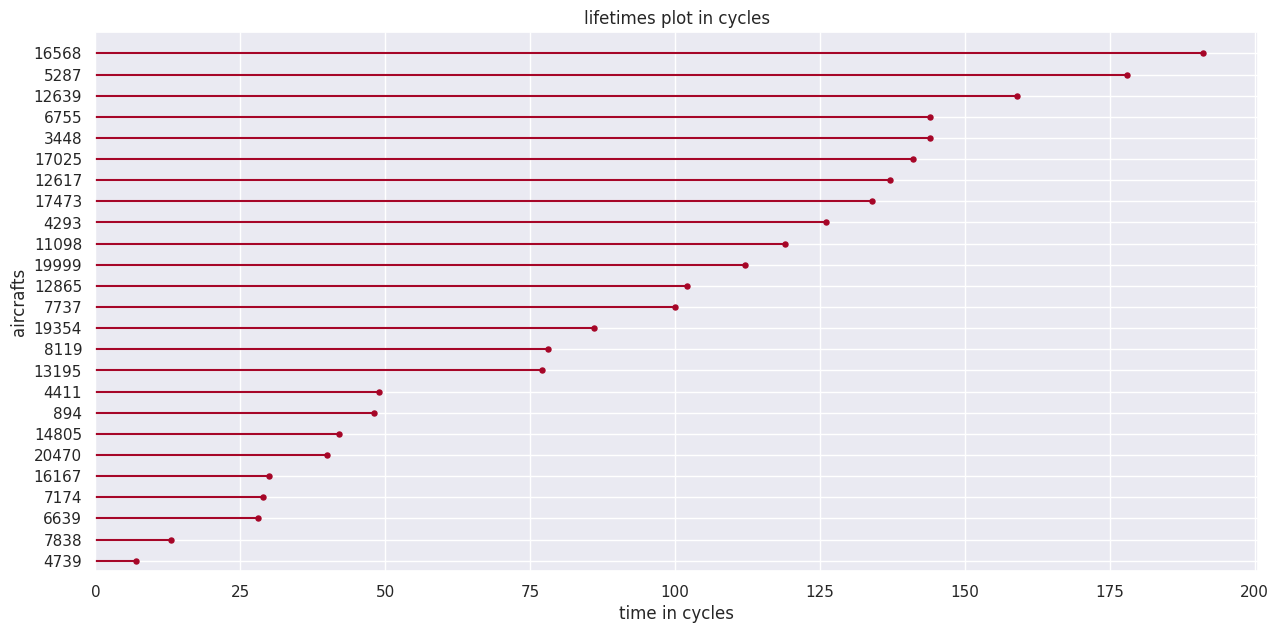

In [ ]:
# lifelines plot of the dataset to show days survived and death event occurence
df=train_censored[train_cols1].sample(25)  # random sampling of data
plt.figure(figsize=[15,7])
plot_lifetimes(df['time_cycles'])
plt.title('lifetimes plot in cycles')
plt.xlabel('time in cycles')
plt.ylabel('aircrafts')
plt.show()

<Axes: >

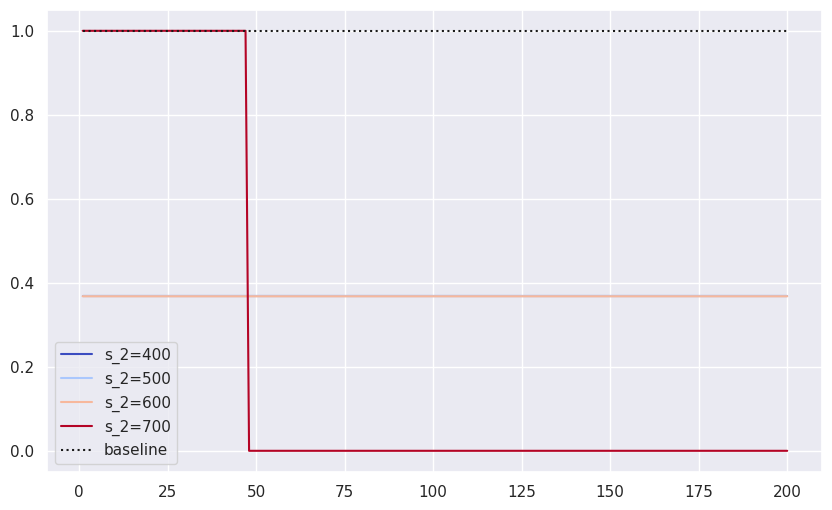

In [ ]:
plt.subplots(figsize=(10, 6))
aft.plot_partial_effects_on_outcome('s_2', range(400, 800, 100), cmap='coolwarm')

In [ ]:

# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()
# Fit to data
for model in [wb, ex, log, loglogis]:
    model.fit(durations=train_censored["time_cycles"], event_observed=train_censored["breakdown"])
    # Print AIC
    print("The AIC, BIC value for", model.__class__.__name__, "are",  model.AIC_, model.BIC_)

The AIC, BIC value for WeibullFitter are 900.1564914882468 915.8212263283128
The AIC, BIC value for ExponentialFitter are 1232.4932544685887 1240.3256218886218
The AIC, BIC value for LogNormalFitter are 907.5497179557254 923.2144527957914
The AIC, BIC value for LogLogisticFitter are 900.7074346000985 916.3721694401645


In [ ]:
!pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.0 MB/s eta 0:00:00


In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sksurv.util import Surv

In [ ]:
# Create a pipeline for scaling the features and fitting the Cox proportional hazards model
pipeline = make_pipeline(
    StandardScaler(),
    CoxPHSurvivalAnalysis(),
)
test_censored = test[test['time_cycles'] <= cut_off].copy()
X_test = test_censored.groupby('unit_nr').last()[remaining_sensors]
df_test["breakdown"] = 1
y_array = df_test[["breakdown", "time_cycles"]].values
# List of tuples
aux = [(e1, e2) for e1, e2 in y_array]
# Structured array
y_test = np.array(aux, dtype=[('breakdown', '?'), ('time_cycles', '<f8')])
X_train = train_censored[remaining_sensors]
y_train = Surv().from_dataframe("breakdown", "time_cycles", train_censored)
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)
# Evaluate the pipeline on the testing data
score = pipeline.score(X_test, y_test)
print(f"Concordance index: {score:.3f}")
X_test

Concordance index: 0.791


,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
unit_nr,,,,,,,,,,,,,,
1,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393,38.81,23.3552
2,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391,38.81,23.2618
3,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395,38.93,23.2740
4,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395,38.58,23.2581
5,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,642.30,1590.88,1397.94,553.99,2388.03,9062.41,47.14,522.30,2388.01,8148.24,8.4110,391,38.96,23.4606
97,642.59,1582.96,1410.92,554.05,2388.06,9076.36,47.38,521.58,2388.06,8155.48,8.4500,395,38.61,23.2953
98,642.68,1599.51,1415.47,553.44,2388.13,9062.34,47.66,521.53,2388.09,8146.39,8.4235,394,38.76,23.3608


In [ ]:
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw
from sksurv.metrics import cumulative_dynamic_auc
from sklearn.inspection import permutation_importance
from sksurv.ensemble import RandomSurvivalForest

rsf_params = {
        "n_estimators": 50,
        "max_depth": 6,
        # "min_samples_split": 10
        # "min_samples_leaf": 15
        "n_repeats": 5,
        "max_features": 5,
        "random_state": 0
    }
# target
y_test = np.array(
    list(zip(df_test.loc[:, "breakdown"], df_test.loc[:, "time_cycles"])),
    dtype=[("breakdown", bool), ("time_cycles", float)]
)

rsf_model = make_pipeline(
        StandardScaler(),
        # check balanced target classes when splitting: w and w/0 observed events
        RandomSurvivalForest(
            n_estimators=rsf_params["n_estimators"],
            max_depth=rsf_params["max_depth"],
            # min_samples_split=rsf_params["min_samples_split"],
            # min_samples_leaf=rsf_params["min_samples_leaf"],
            n_jobs=-1,
            random_state=rsf_params["random_state"]
        )
    )

# Fit the pipeline to the training data
rsf_model.fit(X_train, y_train)
# Evaluate the pipeline on the testing data
score = rsf_model.score(X_test, y_test)
print(f"Concordance index: {score:.3f}")

Concordance index: 0.649


In [ ]:
res = permutation_importance(
    rsf_model, X_test, y_test,
    n_repeats=rsf_params["n_repeats"],
    random_state=rsf_params["random_state"]
)

res_df = pd.DataFrame(
    {k: res[k] for k in ["importances_mean", "importances_std"]},
    index=X_test.columns
).sort_values(by=["importances_mean"], ascending=False)
print("Features importance sorted:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(res_df)
print()

top_features = res_df.index[:rsf_params["max_features"]].tolist()
print("top_features:", top_features)
print()

Features importance sorted:
      importances_mean  importances_std
s_14          0.018754         0.013938
s_17          0.014905         0.009507
s_12          0.012116         0.002696
s_7           0.011362         0.009627
s_15          0.009631         0.005051
s_20          0.008959         0.004442
s_4           0.008064         0.008415
s_11          0.007575         0.004355
s_21          0.005009         0.007726
s_9           0.003563         0.005637
s_8           0.003177         0.005745
s_2           0.002321         0.003751
s_3          -0.000041         0.000081
s_13         -0.000061         0.000285

top_features: ['s_14', 's_17', 's_12', 's_7', 's_15']



Dynamic ROC curve
Censoring_ratio: 0.003
1 1 200 200
0 s_14 <class 'tuple'> 
 (0.5353863695077263, 2740, 2170, 1, 0)
1 s_17 <class 'tuple'> 
 (0.6466179363853781, 2999, 991, 921, 0)
2 s_12 <class 'tuple'> 
 (0.3045209574990034, 1224, 3671, 16, 0)
3 s_7 <class 'tuple'> 
 (0.351227122687221, 1386, 3512, 13, 0)
4 s_15 <class 'tuple'> 
 (0.6661953103144316, 3569, 1339, 3, 0)
       c_index  num_concordant_pairs  num_discordant_pairs  tied_risk  \
s_14  0.535386                  2740                  2170          1   
s_17  0.646618                  2999                   991        921   
s_12  0.304521                  1224                  3671         16   
s_7   0.351227                  1386                  3512         13   
s_15  0.666195                  3569                  1339          3   

      tied_time  
s_14          0  
s_17          0  
s_12          0  
s_7           0  
s_15          0  


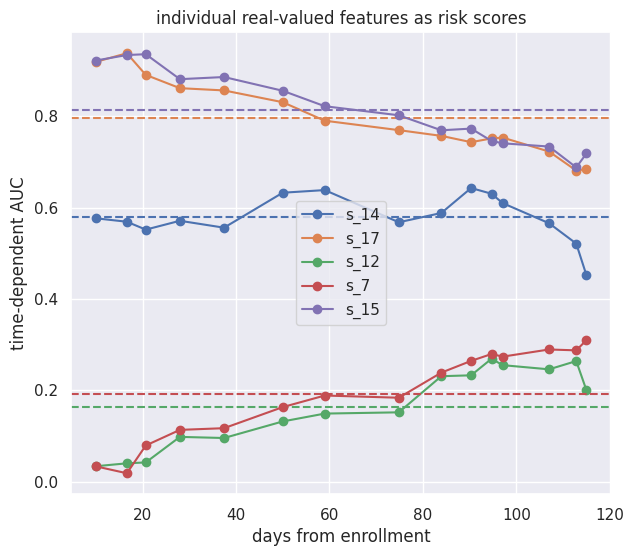

In [ ]:
# dynamic ROC curve
print("Dynamic ROC curve")
censoring_ratio = np.round((train_censored["breakdown"] == True).sum() / len(train_censored), 3)
print("Censoring_ratio:", censoring_ratio)
# c_index_f = concordance_index_censored if censoring_ratio < 0.5 else concordance_index_ipcw

# check observed times of test data lies within observed time range of training data
train_min, train_max = train_censored["time_cycles"].min(), train_censored["time_cycles"].max()
test_min, test_max = test_censored["time_cycles"].min(), test_censored["time_cycles"].max()
print(train_min, test_min, test_max, train_max)
assert train_min <= test_min < test_max <= train_max,\
"Time range of test data is not within time range of training data"

# time points to evaluate dynamic ROC curve
times = np.percentile(y_test["time_cycles"], np.linspace(5, 81, 15))

# plot dynamic ROC
# first plot
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")

fig, ax = plt.subplots(figsize=(8, 6))
rets = []
for i, col in enumerate(top_features):
    X_test_data = X_test.loc[:, col]
    plot_cumulative_dynamic_auc(X_test_data, col, color="C{}".format(i))
    ret = concordance_index_ipcw(y_train, y_test, X_test_data, tau=times[-1])
    rets.append(ret)
    print(i, col, type(ret), "\n", ret)

plt.legend(loc="best")
plt.title("individual real-valued features as risk scores")
plt.subplots_adjust(right=0.8)

# concordance index
ret_df = pd.DataFrame(rets, index=top_features, columns=[
    "c_index", "num_concordant_pairs", "num_discordant_pairs", "tied_risk", "tied_time"
])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(ret_df)

In [ ]:
from sksurv.svm import FastSurvivalSVM

estimator = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)

def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y['breakdown'], y['time_cycles'], prediction)
    return result[0]

svm_model = make_pipeline(
        StandardScaler(),
        # check balanced target classes when splitting: w and w/0 observed events
        estimator
    )

# Fit the pipeline to the training data
svm_model.fit(X_train, y_train)
# Evaluate the pipeline on the testing data
score = svm_model.score(X_test, y_test)
print(f"Concordance index: {score:.3f}")

print(score_survival_model(svm_model, X_test, y_test))

Concordance index: 0.784
0.7837507635919365
